In [1]:
import daal4py.sklearn
daal4py.sklearn.patch_sklearn()
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import warnings
warnings.filterwarnings("ignore")

dispatcher.py:151: FutureWarning: 
Scikit-learn patching with daal4py is deprecated and will be removed in the future.
Use Intel(R) Extension for Scikit-learn* module instead (pip install scikit-learn-intelex).
To enable patching, please use one of the following options:
1) From the command line:
    python -m sklearnex <your_script>
2) From your script:
    from sklearnex import patch_sklearn
    patch_sklearn()
Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


# Prepare data

In [2]:
# Load digits dataset and separate features and targets
dataset = load_digits()
X, y = dataset["data"], dataset["target"]

In [3]:
print(f"Features array shape: {X.shape} target array shape: {y.shape}")

Features array shape: (1797, 64) target array shape: (1797,)


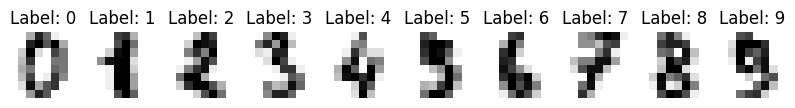

In [4]:
# plot a sample per class
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 3))
for ax, image, label in zip(axes, X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape(8,8), cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Label: %i" % label)

In [5]:
# Split dataset into train and test with 20% for test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeling

In [6]:
# Use GridSearch to find the best parameters for an SVM algorithm using the accuracy as metric and 5-folds for cross validation
time_start = time.time()
svm = SVC()

parameters = [ 
    {'C':[1, 10, 100, 1000]},
    {'kernel':['linear']},
    {'kernel':['rbf'], 'gamma':[0.1, 0.3, 0.5, 0.7, 0.9]},
    {'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01, 0.03, 0.05]} 
]

grid_search = GridSearchCV(estimator=svm, param_grid=parameters, scoring='accuracy', cv=5, verbose=0)
grid_search.fit(X_train, y_train)

# print GridSearch results
print('Best Parameters: ', grid_search.best_params_)
print('Best score: ', grid_search.best_score_)
print('Score on test set: ', grid_search.score(X_test, y_test))

time_daal = time.time() - time_start     
print("Time for model training using GridSearch", time_daal) 

Best Parameters:  {'C': 10}
Best score:  0.9916545683313978
Score on test set:  0.9861111111111112
Time for model training using GridSearch 3.19156813621521


=> The best parameters are kernel="rbf" (default) and C=10

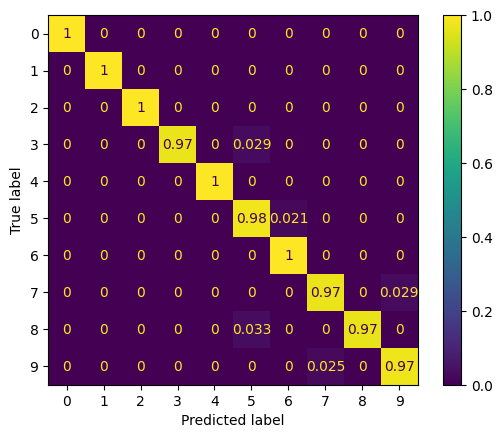

In [7]:
# Confusion matrix
cm = confusion_matrix(y_test, grid_search.predict(X_test))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
ConfusionMatrixDisplay(cmn).plot()
plt.show()

In [8]:
# Other metrics
print(classification_report(y_test, grid_search.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        28
           2       1.00      1.00      1.00        33
           3       1.00      0.97      0.99        34
           4       1.00      1.00      1.00        46
           5       0.96      0.98      0.97        47
           6       0.97      1.00      0.99        35
           7       0.97      0.97      0.97        34
           8       1.00      0.97      0.98        30
           9       0.97      0.97      0.97        40

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360



## Compare with and without oneDAL

In [9]:
%store -r time_nodaal

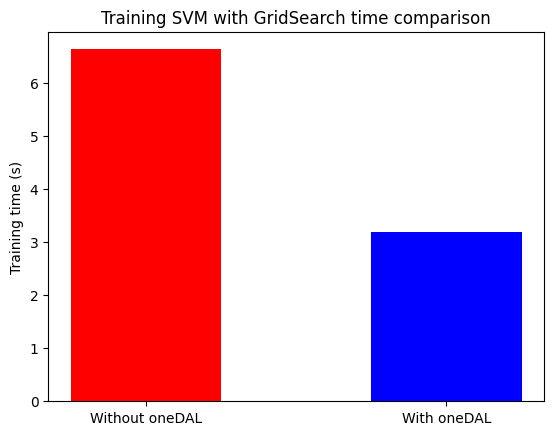

speedup: 2.078248405266626


In [11]:
left = [1,2]
pred_times = [time_nodaal,time_daal ]
tick_label = ['Without oneDAL', 'With oneDAL']
plt.bar(left, pred_times, tick_label = tick_label, width = 0.5, color = ['red', 'blue'])
plt.title('Training SVM with GridSearch time comparison')
plt.ylabel('Training time (s)')
plt.show()

print("speedup:",time_nodaal/time_daal)